# Ejmplo Random Forest para clasificacion
### Examen Mayo 2024


## Librerias y carga del dataset

In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
# Cargar datos
df = pd.read_csv('mushroom.csv')
copy_df_class = df["class"]
display(df)

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,1371.0,2,2,10,3.807467,1545.0,11,1.804273,1
1,1461.0,2,2,10,3.807467,1557.0,11,1.804273,1
2,1371.0,2,2,10,3.612496,1566.0,11,1.804273,1
3,1261.0,6,2,10,3.787572,1566.0,11,1.804273,1
4,1305.0,6,2,10,3.711971,1464.0,11,0.943195,1
...,...,...,...,...,...,...,...,...,...
54030,73.0,5,3,2,0.887740,569.0,12,0.943195,1
54031,82.0,2,3,2,1.186164,490.0,12,0.943195,1
54032,82.0,5,3,2,0.915593,584.0,12,0.888450,1
54033,79.0,2,3,2,1.034963,491.0,12,0.888450,1


## Limpieza de los Datos con Funcion

In [2]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

def clean_and_split2(df: pd.DataFrame,
                    col_objetivo: str,
                    test_size: float = 0.2,
                    random_state: int = 13):
    
    # Contar NaNs antes de limpiar
    nan_counts_before = df.isna().sum()  # cuenta de valores faltantes por col
    print("Valores faltantes antes de la limpieza:\n", nan_counts_before)

    # Se eliminan todas las filas que contienen al menos un valor nulo
    #df = df.dropna(how='any') 
    
    # 1. Extraer la col objetivo del resto de las características del DF, separar X e y
    y = df[col_objetivo].values  # objetivo como array numpy
    X = df.drop(columns=[col_objetivo])  # elimina la col objetivo

    # 2. Separar entre columnas numéricas y categoricas
    numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
    categoric_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

    # 3. Definir pipeline para porcesar cols numericas
    # Vamos a quitar los NaN y una normalizacion a 0-1
    numeric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # sustituye NaN por media
        ('scaler', MinMaxScaler())  # normaliza valores al rango [0,1]
    ])

    # 4. Definir pipeline para porcesar cols categoricas
    # Vamos a quitar los NaN y hacer codificaion OneHot
    categoric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),  # sustituye NaN por moda
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))  # codifica categorias, OneHot
    ])

    # 5. Combinar los pipelines en el prepocesor
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_pipeline, numeric_cols),  # aplica a num_cols
        ('cat', categoric_pipeline, categoric_cols)   # aplica a cat_cols
    ])

    # 6. Ajustar transformaciones y transformar datos
    X_processed = preprocessor.fit_transform(X)

    # Contar NaNs despues de la limpieza (ya no deberia haber)
    # DataFrame temporal para comprobalo
    nuevo_df = pd.DataFrame(X_processed)
    nan_cont_desp = nuevo_df.isna().sum()
    print("Valores faltantes después de la limpieza:\n", nan_cont_desp)

    # 7. Division en train y test
    X_train, X_test, y_train, y_test = train_test_split(
        X_processed, y,
        test_size=test_size,
        random_state=random_state
    )

    return X_train, X_test, y_train, y_test



#Utilizamos la funcion para obtener los datos de entrenamiento y test
col_objetivo = "class"
X_train, X_test, y_train, y_test = clean_and_split2(df, col_objetivo)
print("Train shape:", X_train.shape)
print("Test  shape:", X_test.shape)


Valores faltantes antes de la limpieza:
 cap-diameter       2
cap-shape          0
gill-attachment    0
gill-color         0
stem-height        0
stem-width         2
stem-color         0
season             0
class              0
dtype: int64
Valores faltantes después de la limpieza:
 0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64
Train shape: (43228, 8)
Test  shape: (10807, 8)


# Random Forest Clasificacion

In [3]:
# Random Forest
from sklearn.metrics import accuracy_score # función para calcular la proporción de predicciones correctas
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=20, random_state=13,n_estimators=400)
# 20 : Límite de profundidad de cada árbol
# 400 : es un numero de arboles robusto
clf.fit(X_train, y_train)

y_predict_RF = clf.predict(X_test)
ac = accuracy_score(y_predict_RF,y_test)
print("Accuracy",ac)

Accuracy 0.9909318034607199


## Random Forest con GridSearch

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Definir Random Forest base
rf = RandomForestClassifier(random_state=13)

# Rejilla de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 400, 800],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Configurar GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Ejecutar búsqueda de hiperparámetros
grid_search_rf.fit(X_train, y_train)

# Resultados de validación cruzada
print("Mejores parámetros RF:", grid_search_rf.best_params_)
print("Mejor score CV RF:", grid_search_rf.best_score_)

# Evaluar en test con el mejor estimador
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
test_acc_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy RF en test:", test_acc_rf)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


KeyboardInterrupt: 

## Mostrar resultados:
### Matriz de Confusion

Matriz de confusion MLP:


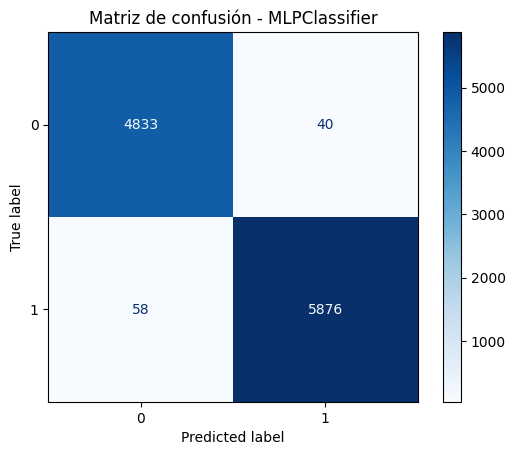


Falsos positivos RF: 58

Falsos negativos RF: 58

Accuracy 0.9909318034607199

precision_score 0.993238674780257

recall_score 0.9902258173238961

f1_score 0.9917299578059072


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

#Crear la Matriz de confusion
cm_RF = confusion_matrix(y_test, y_predict_RF)
print("Matriz de confusion Random Forest:")
#print(cm_RF)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_RF)
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de confusión - RFClassifier')
plt.show()
# (0,0) TN: Verdaderos negativos
# (0,1) FP: Falsos positivos (¡esto es lo que quieres!)
# (1,0) FN: Falsos negativos
# (1,1) TP: Verdaderos positivos

fp_rf = cm_RF[0, 1]
fn_rf = cm_RF[1, 0]
print("\nFalsos positivos RF:", fp_rf)
print("\nFalsos negativos RF:", fn_rf)

'''
Cuándo priorizar cada una:

    Si te preocupan FP (falsos positivos), examina precision.

    Si temes mas FN (falsos negativos), mira recall.

    El F1-score equilibra ambas.
'''

acc = accuracy_score(y_test, y_predict_RF)
print("\nAccuracy",ac) #ya lo muestro antes al hacer el modelo
prec = precision_score(y_test, y_predict_RF)
print("\nprecision_score",prec)
rec = recall_score(y_test, y_predict_RF)
print("\nrecall_score",rec)
f1 = f1_score(y_test, y_predict_RF)
print("\nf1_score",f1)

# Limpieza de datos a mano
### Codificacion OneHot Enconder (OHE)
### Imputar una columna
Significa que vamos a rellenar los datos que faltan de una columna, normalmente con la media


In [ ]:
# Imports
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.impute import SimpleImputer

# Lo primero es cargar el df
mushroomOriginal = pd.read_csv('mushroom.csv')

copy_df = mushroomOriginal #copia para hacer PCA

#ELIMINAR VALORES NULOS
# Buscamos si hay valores nulos
countNaN = mushroomOriginal.isna().sum()
print("Columnas con valores nulos:")
print(countNaN)
print("\n")

# Si los hay, se elminan o tambien se pueden imputar (rellenar huecos con la media de esos valores)
# Ojo, las cols categoricas no se pueden imputar claro, se borran las filas y ya

# Imputamos la columna cap-diameter por ejemplo, que tiene 2 valores NaN
imputer = SimpleImputer(strategy='mean')        #Declaramos el imputer, usamos como referencia la media, tambien esta la moda "mode"
cap_diameter = mushroomOriginal["cap-diameter"].to_numpy().reshape(-1, 1) #Transf los valores de la col a [-1, 1]
cap_diameter_clean = imputer.fit_transform(cap_diameter)        #Se apliac el imputerr en los datos transf de la col
mushroomOriginal["cap-diameter"] = cap_diameter_clean           #Sustituimos los valores de antes a los limpios

# Eliminar el resto de NaN
mushroomOriginal = mushroomOriginal.dropna(how='any') # Se eliminan todas las filas que contienen al menos un valor nulo
countNaN = mushroomOriginal.isna().sum()
# Demostrar que no quedan valores nulos
print("Columnas con valores nulos:") 
print(countNaN) 
print("\n")

#COLUMNA OBJETIVO
# La col que queremos clasificar es Class, para ver cuantas clases hay:
class_distribution = mushroomOriginal["class"].value_counts()
print("Tipos de clases de class y numero de veces que aparecen cada uno:")
print(class_distribution) # En este caso solo hay dos tipos, 0 o 1 pero podria ser categorica
print("\n")

# Separo la sol que busco
# Si la sol fuese categorica, deberiamos hacer OHE o LabelEncoding
Y = mushroomOriginal["class"].to_numpy() # Paso a numerico (Venenoso no venenoso -> 0 o 1) y lo meto en Y
mushroomOriginal=mushroomOriginal.drop("class",axis=1)  # Elimino del dataframe la col que me da la solucion


#TRANSFORMAR COLUMNAS CATEGORICAS
#Ahora vamos a aplicar One Hot Encoding (OHE) para las cols categoricas
encoder = OneHotEncoder(sparse_output=False)
display(mushroomOriginal)       #Son catergoricas aquellas que no son valor numerico continuo
print("\n")


# Pasar los valores de la columna 'x' de 'lo que sea' a valores numericos
cap_shape=mushroomOriginal["cap-shape"].to_numpy()
gill_attachment=mushroomOriginal["gill-attachment"].to_numpy()
gill_color=mushroomOriginal["gill-color"].to_numpy()
stem_color=mushroomOriginal["stem-color"].to_numpy()

# Crear nuevas cols para cada col categorica, dejando los valores entre -1 y 1.  
cap_shapeOHE = encoder.fit_transform(cap_shape.reshape(-1, 1))
gill_attachmentOHE = encoder.fit_transform(gill_attachment.reshape(-1, 1))
gill_colorOHE = encoder.fit_transform(gill_color.reshape(-1, 1))
stem_colorOHE = encoder.fit_transform(stem_color.reshape(-1, 1))

# Eliminar las columnas originales
mushroomOriginal=mushroomOriginal.drop("cap-shape",axis=1)
mushroomOriginal=mushroomOriginal.drop("gill-attachment",axis=1)
mushroomOriginal=mushroomOriginal.drop("gill-color",axis=1)
mushroomOriginal=mushroomOriginal.drop("stem-color",axis=1)

#Las columnas que ya eran numericas, las pasamos a numpy(estan como strings)
X = mushroomOriginal.to_numpy()
print("Columnas que ya eran numeros:")
print(X.shape)
print("\n")

# Meto las columnas que he creado con One-Hot de vuelta al df (antes categoricas, ahora valores numericos entre -1 y 1)
X = np.hstack((X,cap_shapeOHE))
X = np.hstack((X,gill_attachmentOHE))
X = np.hstack((X,gill_colorOHE))
X = np.hstack((X,stem_colorOHE))
print("DF con cols transformadas a OneHot")
print(X.shape)
print("\n")


# Se normalizan los valores de X entre 0 y 1 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Dividir datos (dividir 80% train, 20% test)
print(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=13)

Columnas con valores nulos:
cap-diameter       2
cap-shape          0
gill-attachment    0
gill-color         0
stem-height        0
stem-width         2
stem-color         0
season             0
class              0
dtype: int64


Columnas con valores nulos:
cap-diameter       0
cap-shape          0
gill-attachment    0
gill-color         0
stem-height        0
stem-width         0
stem-color         0
season             0
class              0
dtype: int64


Tipos de clases de class y numero de veces que aparecen cada uno:
class
1    29674
0    24359
Name: count, dtype: int64




,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season
0,1371.0,2,2,10,3.807467,1545.0,11,1.804273
1,1461.0,2,2,10,3.807467,1557.0,11,1.804273
2,1371.0,2,2,10,3.612496,1566.0,11,1.804273
3,1261.0,6,2,10,3.787572,1566.0,11,1.804273
4,1305.0,6,2,10,3.711971,1464.0,11,0.943195
...,...,...,...,...,...,...,...,...
54030,73.0,5,3,2,0.887740,569.0,12,0.943195
54031,82.0,2,3,2,1.186164,490.0,12,0.943195
54032,82.0,5,3,2,0.915593,584.0,12,0.888450
54033,79.0,2,3,2,1.034963,491.0,12,0.888450




Columnas que ya eran numeros:
(54033, 4)


DF con cols transformadas a OneHot
(54033, 43)


[[0.72501322 0.99273698 0.43289437 ... 0.         1.         0.        ]
 [0.77260709 0.99273698 0.43625665 ... 0.         1.         0.        ]
 [0.72501322 0.94189582 0.43877837 ... 0.         1.         0.        ]
 ...
 [0.0433633  0.23864218 0.16363127 ... 0.         0.         1.        ]
 [0.04177684 0.26976942 0.13757355 ... 0.         0.         1.        ]
 [0.03807509 0.30193424 0.13785374 ... 0.         0.         1.        ]]


# Diagrama de Nube
## PCA
Muestra en una gráfica 2D de nube de puntos, como está distribuida las dos clases y en base a lo que se ve, di de forma razonada si crees que al menos a simple vista parece que las clases sean linealmente separables o no.

Hay que usar PCA para poder mostrar solo las 2 componentes principales.

Tipos de clases de class y numero de veces que aparece cada uno:
class
1    29674
0    24359
Name: count, dtype: int64


-------------- No es comestible ---------------


,cap-diameter,stem-height,stem-width,season,class
717,997.0,2.124354,1722.0,0.943195,0
718,914.0,1.475779,1418.0,0.888450,0
719,865.0,2.104459,1971.0,0.943195,0
720,841.0,2.024880,1384.0,0.888450,0
721,914.0,0.660086,1453.0,0.888450,0
...,...,...,...,...,...
53677,422.0,0.585337,1943.0,0.027372,0
53678,683.0,0.346598,1801.0,0.027372,0
53679,615.0,0.255081,1835.0,0.027372,0
53680,374.0,0.772350,1849.0,0.027372,0


------------- Es comestible ------------------------


,cap-diameter,stem-height,stem-width,season,class
0,1371.0,3.807467,1545.0,1.804273,1
1,1461.0,3.807467,1557.0,1.804273,1
2,1371.0,3.612496,1566.0,1.804273,1
3,1261.0,3.787572,1566.0,1.804273,1
4,1305.0,3.711971,1464.0,0.943195,1
...,...,...,...,...,...
54030,73.0,0.887740,569.0,0.943195,1
54031,82.0,1.186164,490.0,0.943195,1
54032,82.0,0.915593,584.0,0.888450,1
54033,79.0,1.034963,491.0,0.888450,1


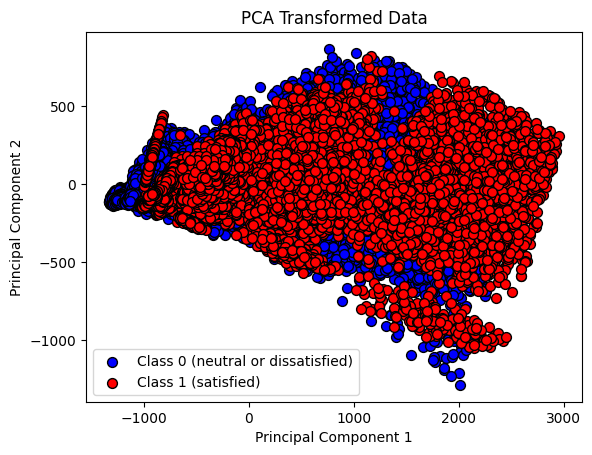

In [ ]:
#!pip install matplotlib
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Creamos una copia del df con la col class objetivo sin modificar
copy_df = mushroomOriginal
copy_df["class"] = copy_df_class # La col class es igual a como era originalmente

# Queremos separar las filas que tienen un valor distinto cada unas de class
# Para ver cuantas clases de "class" hay:
class_distribution = mushroomOriginal["class"].value_counts()
print("Tipos de clases de class y numero de veces que aparece cada uno:")
print(class_distribution) # En este caso solo hay dos tipos, 0 o 1 pero podria ser categorica
print("\n")

# Guardamos un df con todas las filas en las que class == 0, y otro en el que class == 0
class0 = copy_df[copy_df["class"]== 0]
class1 = copy_df[copy_df["class"]== 1]

print("-------------- No es comestible ---------------")
display(class0)
print("------------- Es comestible ------------------------")
display(class1)

#Quitamos la columna class, para tener solamente los datos de cada una
setas_con_class0 = class0.drop("class",axis=1)
setas_con_class1 = class1.drop("class",axis=1)

#Convertimos el resto de datos a numericos
class0X = setas_con_class0.to_numpy()
class1X = setas_con_class1.to_numpy()

#Aplicamos PCA
pca = PCA(n_components=2)
data_pca0X = pca.fit_transform(class0X)
data_pca1X = pca.fit_transform(class1X)

#Mostrar grafica 2D de nube de puntos
plt.scatter(data_pca0X[:, 0], data_pca0X[:, 1], c='blue', edgecolor='k', s=50, label="Class 0 (neutral or dissatisfied)")
plt.scatter(data_pca1X[:, 0], data_pca1X[:, 1], c='red', edgecolor='k', s=50, label="Class 1 (satisfied)")
plt.title("PCA Transformed Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


La grafica no parece indicar que las dos clases sean linealmente independientes

# Variable con mas correlacion a la que queremos clasificar
## Matriz de Correlacion

Atributo con mayor correlación: 'stem-height'
Valor de correlación: 0.1834


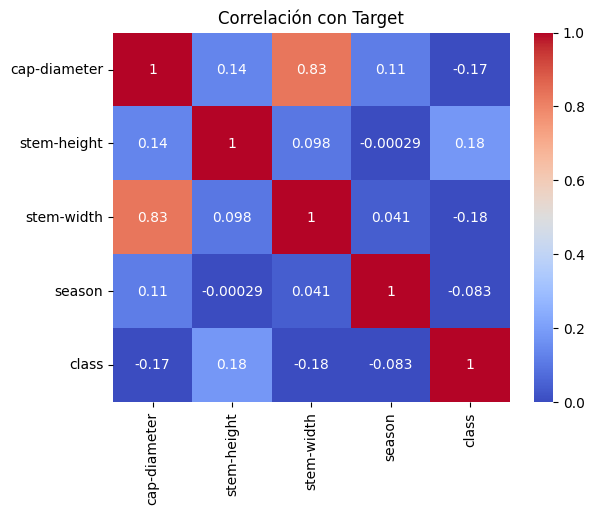

In [ ]:
# 3. Calcular matriz de correlaciones
# Debe ser el df solo con valores numericos, incluida la variable objetivo 
# Es decir, ya todo con OnetHot y pasado a numpy
# Para ello, hacemos una copia del df ya limpiado y anadimos la col objetivo
mushroomOriginal_copy = mushroomOriginal    
mushroomOriginal_copy["class"] = Y          
correlation_matrix = mushroomOriginal.corr()

# 4. Identificar la variable objetivo 
target = 'class'

# 5. Encontrar la correlación más fuerte (ignorando la autocorrelación)
correlations = correlation_matrix[target].drop(target)

strongest_corr = correlations.abs().idxmax()

print(f"Atributo con mayor correlación: '{strongest_corr}'")
print(f"Valor de correlación: {correlations[strongest_corr]:.4f}")

#!pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
# Dibujar mapa de calor
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Correlación con Target')
plt.show()